# NTF analysis of FACS filtrates

In [1]:
#import packages
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text
import scipy
import statistics
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import seaborn as sns
import colorsys
import sys
import operator
import nmtf
from IPython.display import display, HTML, Javascript
from tqdm import tqdm_notebook as tqdm
pd.set_option('display.max_columns', 100)
sns.set_style('darkgrid')
display(HTML("<style>.container { width:90% !important; }</style>"))

## Some parameters have to be set by the user

In [2]:
# Source file location
source_file = './data/ABIS.xlsx'

# FACS cell types proportion and user cell types grouping file
facs_file = './data/ABIS_PBMC_real_compositions.csv'

# Cell type(s) to remove from nmtf computation (if any)
user_source_file_columns_to_remove = {'PBMC'}

# If needed, fill the following list with custom cell types having sparse meta-cell components (see plot of cell #9).
# If this is not filled, cell types representing over 50% of a meta-cell component are used.
# Example: user_sparse_cells = ['Neutrophils', 'Basophils']
user_sparse_cells = []

In [3]:
# Functions

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def compute_hhi(df):
    """Herfindahl–Hirschman Index (HHI) of a vector is the ratio between the square of the sum of its values 
    and the the sum of their square"""
    hhi_table = {}
    components = list(df.columns)
    for comp in components:
        if sum(df[comp]) == 0:
            hhi = np.nan
        else:
            hhi = (sum(df[comp]) * sum(df[comp])) / sum([i*i for i in df[comp]])
        hhi_table[comp] = hhi
    return hhi_table

def get_point_color(val):
    """Get color accordingly to point category"""
    if val == "Low replicates HHI":
        return "black"
    elif val == "Low cell types HHI":
        return "red"
    else:
        return "blue"

def label_point(x, y, profile, val, ax):
    """Add text labels to points on scatterplot"""
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], ' ' + str(point['val']), color=get_point_color(profile[i]))

def label_point_stripplot(data, ax):
    #a = pd.concat({'y': data, 'label': data.index}, axis=1)
    for i, point in data:
        print(i)
        print(point)
        if data[i] > 0.1:
            ax.text(point['y'], str(point['label']))

def generate_palette(N):
    HSV_tuples = [(x * 3.0 / N, 0.8, 0.9) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out

def filter_df(df, col, threshold, op):
    ops = {'>': operator.gt,
           '<': operator.lt,
           '>=': operator.ge,
           '<=': operator.le,
           '=': operator.eq}
    return df.loc[ops[op](df[col], threshold)]

def csv_download(table, table_name):
    js_download = """
    var csv = '%s';

    var filename = '%s.csv';
    var blob = new Blob([csv], { type: 'text/csv;charset=utf-8;' });
    if (navigator.msSaveBlob) { // IE 10+
        navigator.msSaveBlob(blob, filename);
    } else {
        var link = document.createElement("a");
        if (link.download !== undefined) { // feature detection
            // Browsers that support HTML5 download attribute
            var url = URL.createObjectURL(blob);
            link.setAttribute("href", url);
            link.setAttribute("download", filename);
            link.style.visibility = 'hidden';
            document.body.appendChild(link);
            link.click();
            document.body.removeChild(link);
        }
    }
    """ % (table.to_csv(index=True).replace('\n','\\n').replace("'","\'"), table_name)

    return Javascript(js_download)

## Data loading and transformation

Following cell loads ABIS dataset and remove unwanted columns that contain cell types:
* having null values for an entire replicate
* being missing for at least one replicate
* marked for removal by the user in parameters cell

Finally, it transforms an input looking like: 
<div>
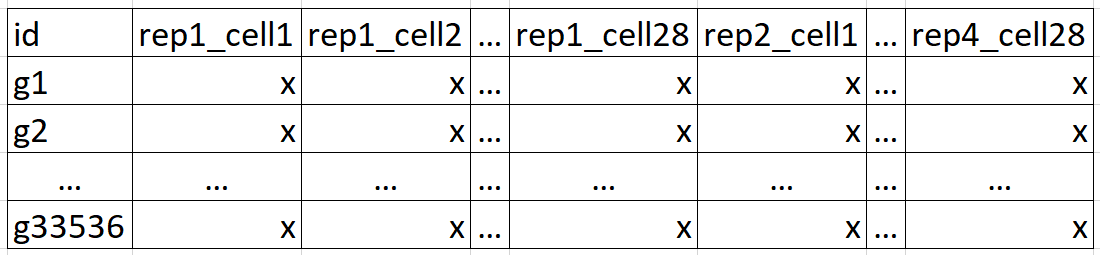
</div>
<br><br><br><br><br><br>
into:
<div>
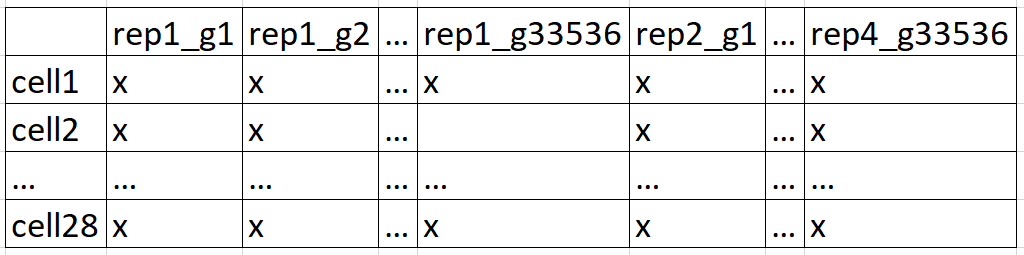
</div>

In [4]:
# Load and transform data

# Loading table from file
source_df = pd.read_excel(source_file)

# Removing columns containing cell types:
#  - having null values for an entire replicate
#  - being missing for at least one replicate
#  - marked for removal by the user in parameters cell
# Resulting dataframe has the same cell types for all replicates
col_headers = list(source_df.columns)
cell_types_to_remove = set()
columns_to_remove = []
replicates = {}
all_cell_types = set()
first_column = True
for col in col_headers:
    if first_column:
        gene_order = source_df[col]
        first_column = False
        continue
    replicate = col.split('_')[0]
    cell_type = '_'.join(col.split('_')[1:])
    all_cell_types.add(cell_type)
    replicates.setdefault(replicate, []).append(cell_type)
    if sum(source_df[col]) == 0:
        cell_types_to_remove.add(cell_type)
for cell_type in all_cell_types:
    for replicate in replicates.keys():
        if cell_type not in replicates[replicate]:
            cell_types_to_remove.add(cell_type)
for cell_type in user_source_file_columns_to_remove:
    for replicate in replicates.keys():
        cell_types_to_remove.add(cell_type)
columns_to_remove = []
for col in col_headers:
    replicate = col.split('_')[0]
    cell_type = '_'.join(col.split('_')[1:])
    if cell_type in cell_types_to_remove:
        columns_to_remove.append(col)
refined_df = source_df.drop(columns_to_remove, axis=1)

# We have a dataframe looking like:
# id      rep1_cell1    rep1_cell2  ...  rep1_cell28    rep2_cell1  ...  rep4_cell28
# g1      x             x                x              x                x
# g2      x             x                x              x                x
# g33536  x             x                x              x                x
# And nmtf package needs:
#           rep1_g1    rep1_g2  ...  rep1_g33536    rep2_g1  ...  rep4_g33536
# cell1     x          x             x              x             x
# cell2     x          x             x              x             x
# ...
# cell28    x          x             x              x             x
#
# So we need to do some concatenation and a transposition
replicates_order = list(refined_df.columns)[1:]
chunk_size = int(len(replicates_order)/len(replicates.keys()))
replicates_subsets = list(chunks(replicates_order, chunk_size))
cell_types_order = []
all_subsets = []
replicates_name_order = []
for header in replicates_subsets[0]:
    cell_types_order.append('_'.join(header.split('_')[1:]))
for header in replicates_subsets:
    replicate_name = header[0].split('_')[0]
    replicates_name_order.append(replicate_name)
cpt = 0
for replicate in replicates_subsets:
    tmp_df = refined_df[replicate]
    tmp_df.columns = cell_types_order
    current_replicate = replicates_name_order[cpt]
    row_names = []
    for gene in gene_order:
        row_names.append(current_replicate + '_' + gene)
    tmp_df.index = row_names
    all_subsets.append(tmp_df)
    cpt += 1
trsp_ready_df = pd.concat(all_subsets)
df = trsp_ready_df.transpose()
df.head()

,925L_37135,925L_37316,925L_37500,925L_37865,925L_38231,925L_38596,925L_38961,925L_39326,925L_39692,925L_40057,925L_40422,925L_40787,925L_41153,925L_41883,925L_5S_rRNA,925L_7SK,925L_A1BG,925L_A1BG-AS1,925L_A2M,925L_A2M-AS1,925L_A2ML1,925L_A2ML1-AS2,925L_A2MP1,925L_A4GALT,925L_AAAS,925L_AACS,925L_AADACL2-AS1,925L_AADACP1,925L_AADAT,925L_AAED1,925L_AAGAB,925L_AAK1,925L_AAMDC,925L_AAMP,925L_AANAT,925L_AAR2,925L_AARD,925L_AARS,925L_AARS2,925L_AARSD1,925L_AASDH,925L_AASDHPPT,925L_AASS,925L_AATBC,925L_AATF,925L_AATK,925L_AB015752.3,925L_AB019440.50,925L_ABALON,925L_ABAT,...,G4YW_ZP2,G4YW_ZP3,G4YW_ZPBP2,G4YW_ZPR1,G4YW_ZRANB1,G4YW_ZRANB2,G4YW_ZRANB2-AS1,G4YW_ZRANB2-AS2,G4YW_ZRANB3,G4YW_ZRSR1,G4YW_ZRSR2,G4YW_ZSCAN10,G4YW_ZSCAN12,G4YW_ZSCAN12P1,G4YW_ZSCAN16,G4YW_ZSCAN16-AS1,G4YW_ZSCAN18,G4YW_ZSCAN2,G4YW_ZSCAN20,G4YW_ZSCAN21,G4YW_ZSCAN22,G4YW_ZSCAN23,G4YW_ZSCAN25,G4YW_ZSCAN26,G4YW_ZSCAN29,G4YW_ZSCAN30,G4YW_ZSCAN31,G4YW_ZSCAN32,G4YW_ZSCAN5A,G4YW_ZSCAN9,G4YW_ZSWIM1,G4YW_ZSWIM3,G4YW_ZSWIM4,G4YW_ZSWIM5,G4YW_ZSWIM6,G4YW_ZSWIM7,G4YW_ZSWIM8,G4YW_ZSWIM8-AS1,G4YW_ZUFSP,G4YW_ZW10,G4YW_ZWILCH,G4YW_ZWINT,G4YW_ZXDA,G4YW_ZXDB,G4YW_ZXDC,G4YW_ZYG11A,G4YW_ZYG11B,G4YW_ZYX,G4YW_ZZEF1,G4YW_ZZZ3
CD8_naive,5767.9102,14.2339,456.8294,0.1704,2.9466,0.0,276.5417,601.9725,6.1776,197.3285,7.4471,28.8434,0.0000,3.5185,7.0160,3.3158,12.3409,8.8771,15.9051,3.0354,0.8455,0.0000,1.5077,0.0,145.9544,36.3310,0.0000,0.0,0.0000,6.9612,57.1072,107.9731,23.2565,82.0215,1.3658,30.1597,0.9822,42.7091,16.6159,39.0415,24.2264,42.9024,11.3012,0.4915,64.2914,2.5129,3.6614,0.0,1.2953,5.8567,...,0.3298,11.6984,0.6298,47.7531,8.3216,231.7596,2.8765,9.8028,12.4726,6.8486,24.9329,0.3900,10.2464,0.1980,13.0950,3.6929,23.2437,15.6996,3.4691,17.8422,6.3514,7.6606,40.1515,24.5470,3.5206,35.4459,5.3891,20.1732,23.1450,1.4393,8.9253,5.7552,0.5880,0.5754,3.3196,20.1018,19.5093,4.5609,16.3069,11.7955,16.5424,4.8865,0.9407,3.1123,10.6370,1.1222,6.6396,71.1373,22.7104,82.0760
CD8_CM,2660.5701,12.8274,352.7868,1.2285,3.1059,0.0,246.4919,512.1187,9.8510,107.9931,2.3171,31.3439,0.8133,2.4724,4.7142,13.6547,6.5113,10.0108,118.7897,14.2577,1.0291,0.6896,13.5383,0.0,79.8406,25.9116,0.0000,0.0,0.0000,5.8695,58.9095,89.6325,12.9959,115.8501,0.0000,28.1058,1.2734,35.3010,21.2194,68.0109,16.8755,21.8886,14.9350,0.1460,84.2295,0.4398,0.8841,0.0,0.8334,5.9149,...,0.2396,4.0879,1.8946,30.8426,5.4282,149.4972,4.3285,22.6583,6.7145,2.2367,26.8024,0.5367,9.5759,0.0896,24.6868,2.6054,9.7691,25.6342,1.4218,15.3068,5.8377,0.0000,29.0349,29.8994,4.6234,22.7999,0.0000,21.2502,12.2419,5.0491,5.8149,1.5094,0.3328,2.4271,2.1122,36.6135,24.1470,7.0692,27.2928,9.9138,17.1909,9.4008,1.4061,4.0518,6.4144,1.2809,4.9767,49.5249,31.9079,91.7374
CD8_EM,5938.2300,7.8285,266.5348,0.0790,3.2462,0.0,198.1626,780.2415,9.1146,132.3575,2.5808,40.4848,0.7142,0.8390,9.9202,0.0000,2.7714,3.6801,132.2954,10.0774,0.6645,0.0000,14.8688,0.0,75.6596,20.4532,0.4895,0.0,0.0000,18.5264,70.4080,83.3343,12.4696,103.0106,0.0632,33.3523,1.2898,33.4163,8.5694,52.0343,14.0832,23.4172,9.5430,0.0000,100.3414,0.1133,0.9957,0.0,0.7369,7.1867,...,0.2805,3.5065,0.1609,15.5019,5.5719,212.6844,0.8541,16.8517,9.0103,3.5931,15.7396,0.8962,4.9386,0.0000,19.7445,0.9606,6.5990,17.6532,2.1392,26.9848,4.6624,0.0000,27.1350,34.9948,5.4987,25.4024,0.3148,29.1007,16.4789,7.7983,4.7315,1.3969,0.7140,1.3847,5.5750,9.9015,47.7480,6.0324,35.1268,16.4949,21.5038,14.2127,1.0543,5.6657,8.1376,0.5958,4.3635,48.9989,24.1672,70.1375
CD8_TE,4095.3999,12.1611,325.9398,0.1833,10.5028,0.0,150.8770,798.7778,6.2325,108.6364,0.0000,35.2940,0.4341,0.4807,13.0313,10.0327,3.2292,6.3499,168.8518,16.3385,0.4648,0.8882,11.4711,0.0,92.6049,23.9380,0.6729,0.0,0.1712,18.4390,51.0573,61.0777,14.2435,116.5198,0.4886,48.0023,1.7681,25.4375,14.0373,50.4135,13.8456,32.3115,14.1618,0.0000,95.0721,0.0000,0.8649,0.0,1.3719,6.6375,...,0.3041,4.8431,1.5312,20.6185,4.8591,120.4255,2.3228,17.9810,8.1956,4.1173,23.4011,0.0000,5.5323,0.1742,18.3140,3.6943,9.8822,29.0150,1.8696,19.1495,7.5226,0.1145,26.9041,

## Next step computes NTF analysis

In [5]:
# Using nmtf package

# nmtf uses values without headers
M0 = df.values
# nc = cell types number (here 28: len(M0))
nc = len(M0)
# NBlocks = number of replicates
NBlocks = len(replicates.keys())
myNTFmodel = nmtf.NTF(n_components=nc)
estimator = myNTFmodel.fit_transform(M0, NBlocks)
estimator = myNTFmodel.predict(estimator)

Step 1 - Quick NMF Ncomp=28: Iteration: 9:  91%|█████████ | 90.90909090909092/100 [00:14<00:01,  5.84it/s] /opt/conda/lib/python3.6/site-packages/tqdm/std.py:538: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)
Step 1 - NTF Ncomp=28: Iteration: 149: 100%|██████████| 100.00000000000016/100 [07:18<00:00,  4.38s/it]     
Leverage: Comp 28: 100%|█████████▉| 99.99999999999997/100 [00:00<00:00, 145.67it/s]               


## Display cell type components

In [6]:
components = []
for i in range(len(estimator['Q'][0])):
    components.append("comp_" + str(i+1))
cell_types_table = pd.DataFrame(data=estimator['W'], index=cell_types_order, columns=components)
display(cell_types_table)

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,comp_11,comp_12,comp_13,comp_14,comp_15,comp_16,comp_17,comp_18,comp_19,comp_20,comp_21,comp_22,comp_23,comp_24,comp_25,comp_26,comp_27,comp_28
CD8_naive,0.306779,0.065142,0.199414,0.332948,0.000000,0.010323,0.000000,0.000000,0.000000,0.000000,0.069248,0.000000,0.000000,0.000000,0.000000,0.256050,0.000000,0.000000,0.002285,0.000000,0.000000,0.000000,0.084134,0.361894,0.000000,0.322351,0.062794,0.000000
CD8_CM,0.216716,0.282655,0.179566,0.165780,0.000000,0.037238,0.000000,0.000000,0.000281,0.000000,0.182902,0.004674,0.001528,0.000000,0.000000,0.321364,0.004476,0.004282,0.043153,0.000000,0.000000,0.000649,0.321541,0.000000,0.005711,0.326758,0.014316,0.008472
CD8_EM,0.273328,0.048429,0.089636,0.020089,0.000000,0.309479,0.000000,0.000000,0.007631,0.000000,0.101046,0.310605,0.016786,0.000000,0.000000,0.147682,0.000000,0.005672,0.213464,0.000000,0.000000,0.023715,0.096966,0.000000,0.004407,0.122226,0.000000,0.012740
CD8_TE,0.162560,0.211217,0.159206,0.035692,0.000000,0.272218,0.000000,0.000000,0.000000,0.000000,0.547089,0.411855,0.000000,0.000000,0.000000,0.017212,0.000000,0.000000,0.195483,0.000000,0.000000,0.000000,0.187594,0.050988,0.000000,0.128207,0.007646,0.000000
MAIT,0.221348,0.297588,0.295699,0.250701,0.000000,0.266484,0.000000,0.000000,0.003040,0.000000,0.012453,0.165397,0.004204,0.000000,0.000000,0.271252,0.000000,0.124346,0.043754,0.005141,0.000000,0.000000,0.304475,0.076649,0.000000,0.000000,0.003298,0.001352
VD2+,0.067830,0.294487,0.314948,0.034880,0.000000,0.149736,0.000000,0.000000,0.005579,0.000000,0.459327,0.358768,0.009927,0.000000,0.000000,0.064257,0.000000,0.046109,0.003637,0.000000,0.000000,0.000000,0.165916,0.249593,0.000000,0.109154,0.009364,0.000000
VD2-,0.258495,0.250029,0.204883,0.033455,0.000000,0.000000,0.000000,0.000000,0.015248,0.000000,0.065888,0.544319,0.019754,0.001075,0.000000,0.000000,0.000000,0.026360,0.043689,0.000000,0.000000,0.000000,0.321947,0.042234,0.000000,0.127957,0.000000,0.000000
TFH,0.203204,0.071364,0.284085,0.249143,0.000000,0.476632,0.000000,0.000000,0.009741,0.000000,0.209688,0.028708,0.000000,0.004947,0.000000,0.298185,0.009727,0.005473,0.003291,0.000000,0.026511,0.000000,0.141639,0.002664,0.000000,0.352691,0.000000,0.018340
Treg,0.118106,0.085506,0.284568,0.187485,0.000000,0.424299,0.000000,0.000000,0.005265,0.000000,0.217722,0.000000,0.000000,0.000000,0.000000,0.286510,0.006816,0.049564,0.071274,0.000000,0.012185,0.000000,0.251682,0.063590,0.000000,0.282712,0.000000,0.012630
Th1,0.311985,0.161875,0.251912,0.218409,0.000000,0.093891,0.000000,0.000000,0.000000,0.000000,0.153327,0.000000,0.008701,0.008844,0.000000,0.242209,0.003599,0.000000,0.000394,0.000000,0.017954,0.000000,0.336921,0.079320,0.000000,0.463506,0.000000,0.000000


## Display subject components

In [7]:
replicates_table = pd.DataFrame(data=estimator['Q'], index=replicates_name_order, columns=components)
display(replicates_table)

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,comp_11,comp_12,comp_13,comp_14,comp_15,comp_16,comp_17,comp_18,comp_19,comp_20,comp_21,comp_22,comp_23,comp_24,comp_25,comp_26,comp_27,comp_28
925L,5862.192505,183278.626621,0.000000,0.000000,46663.787307,71070.096340,9944.496457,0.000000,41730.066448,87373.798687,0.000000,43649.485838,31371.868199,73018.844180,31906.466912,47464.494340,27758.462017,23609.021352,28434.495520,38167.989347,0.000000,35941.336897,0.000000,24854.053462,26652.686856,40241.486939,40986.441249,38364.133429
9JD4,12079.760061,3166.804928,29617.449401,159464.212795,31724.516207,4151.499985,29429.359168,58543.027730,59941.916915,12282.905599,0.000000,68896.103438,46933.697396,11744.870361,22623.170826,47903.069812,35339.498972,0.000000,23701.455585,31270.662495,27226.957919,28801.485996,21140.294027,31894.994192,3147.004004,31272.450914,24716.764856,39877.376910
DZQV,149480.643055,0.000000,0.000000,28287.159168,123132.542711,0.000000,0.000000,11409.893991,5307.890611,0.000000,77319.956061,55090.693181,42623.340716,0.000000,24883.232491,72289.758230,42062.312411,41582.051408,9164.134532,27945.833897,50645.911203,31683.974729,0.000000,34101.038993,60550.744286,936.893954,21018.295857,36651.427042
G4YW,67428.943100,4008.430779,172613.720822,0.000000,764.327233,0.000000,128644.715614,0.000000,54637.156914,0.000000,25745.976183,43939.680739,43159.904037,0.000000,48172.830776,57098.856040,32749.116523,3885.335694,38601.812749,19732.141035,6546.584102,28411.319032,60189.353859,25472.455808,4149.366942,11606.015346,46283.698617,38324.570233


## Compute inverse Herfindahl–Hirschman Index (HHI) for cell lines and replicates, plot the results

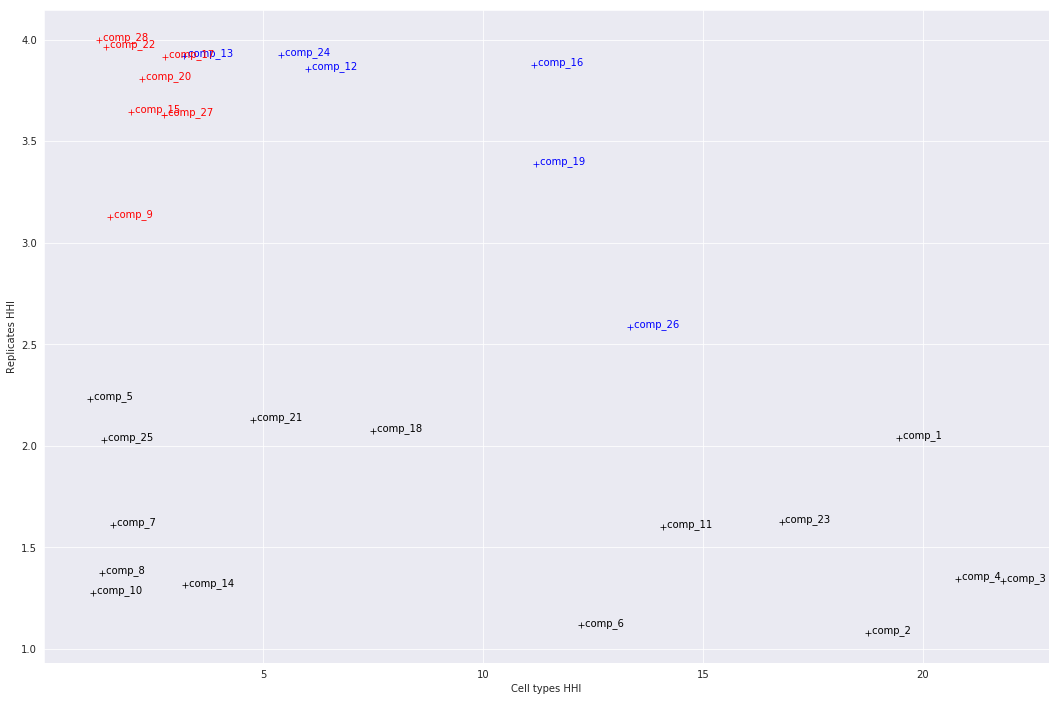

In [8]:
# Compute inverse HHI for cell lines and replicates and display Scatterplot (x = cell lines, y = replicates)

hhi_cell_types = compute_hhi(cell_types_table)
hhi_replicates = compute_hhi(replicates_table)

# Divide components into categories regarding their HHI values accordingly to thresholds
high_replicates_hhi = {}
for comp in hhi_replicates.keys():
    if hhi_replicates[comp] > 2.5:
        high_replicates_hhi[comp] = hhi_replicates[comp]
low_cell_types_hhi = {}
high_cell_types_hhi = {}
for comp in hhi_cell_types.keys():
    if hhi_cell_types[comp] < 3:
        if comp in high_replicates_hhi.keys():
            low_cell_types_hhi[comp] = hhi_cell_types[comp]
    elif comp in high_replicates_hhi.keys():
        high_cell_types_hhi[comp] = hhi_cell_types[comp]

# Set a profile list containing the category of each component
profile = []
x = list(hhi_cell_types.values())
y = list(hhi_replicates.values())
labels = list(hhi_cell_types.keys())
for val in y:
    if labels[y.index(val)] in high_replicates_hhi.keys():
        if labels[y.index(val)] in low_cell_types_hhi.keys():
            profile.append("Low cell types HHI")
        elif labels[y.index(val)] in high_cell_types_hhi.keys():
            profile.append("High cell types HHI")
    else:
        profile.append("Low replicates HHI")

# Set a dataframe containg components names, HHI values and profile information
hhi_data = {'label': labels, 'Cell types HHI': x, 'Replicates HHI': y, 'profile': profile} 
hhi_plot_table = pd.DataFrame(hhi_data)

# Display a scatterplot of these data, colored accordingly to each component category
fig, ax = plt.subplots(figsize=(18, 12))
sns.scatterplot(ax=ax,
                data=hhi_plot_table, 
                x="Cell types HHI",
                y="Replicates HHI",
                hue="profile",
                marker="+", 
                palette=['black','red','blue'],
                legend=False)
label_point(hhi_plot_table['Cell types HHI'], 
            hhi_plot_table['Replicates HHI'],
            hhi_plot_table['profile'], 
            hhi_plot_table.label, 
            ax)

## Plot distribution of sparse meta-cells components

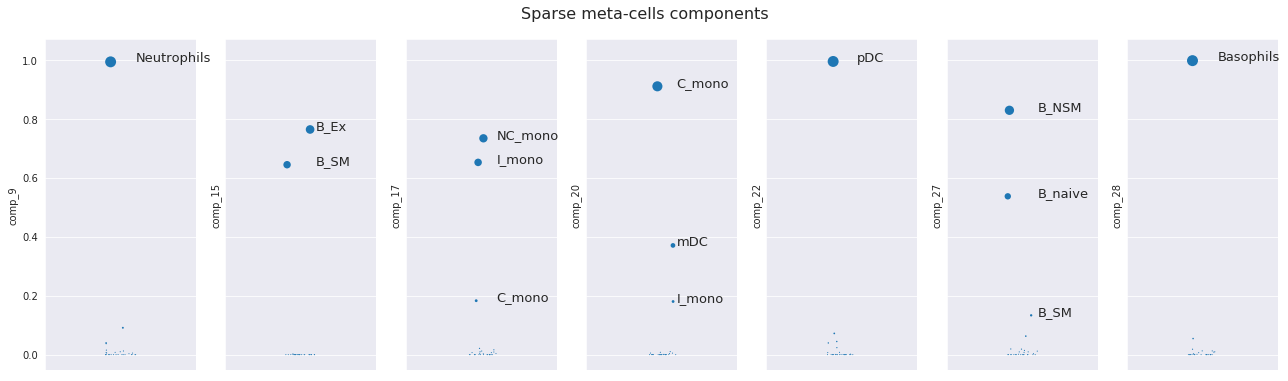

In [9]:
# For sparse meta-cells (low cell types HHI, in red on the scatterplot), display cell types distribution
stripplot_data = []
for comp in low_cell_types_hhi.keys():
    stripplot_data.append(cell_types_table[comp])

fig, axes = plt.subplots(nrows=1, ncols=len(stripplot_data), figsize=(18,5), sharey=True)
fig.subplots_adjust(hspace=1)

sparse_cells = []
for ax, feature in zip(axes.flatten(), stripplot_data):
    points_to_label = feature.index[feature > 0.1].tolist()
    sparse_cells.extend(feature.index[feature > 0.5].tolist())
    sns.stripplot(feature, orient='vert', ax=ax, s=(feature * 10) + 1)
    for point in points_to_label:
        ax.annotate(point, xy=(0.1, feature[point]), xycoords='data', fontsize=13)

fig.suptitle('Sparse meta-cells components', fontsize=16, y=1.05)
plt.tight_layout()

## Plot PCA of meta-cells components representing numerous cell types

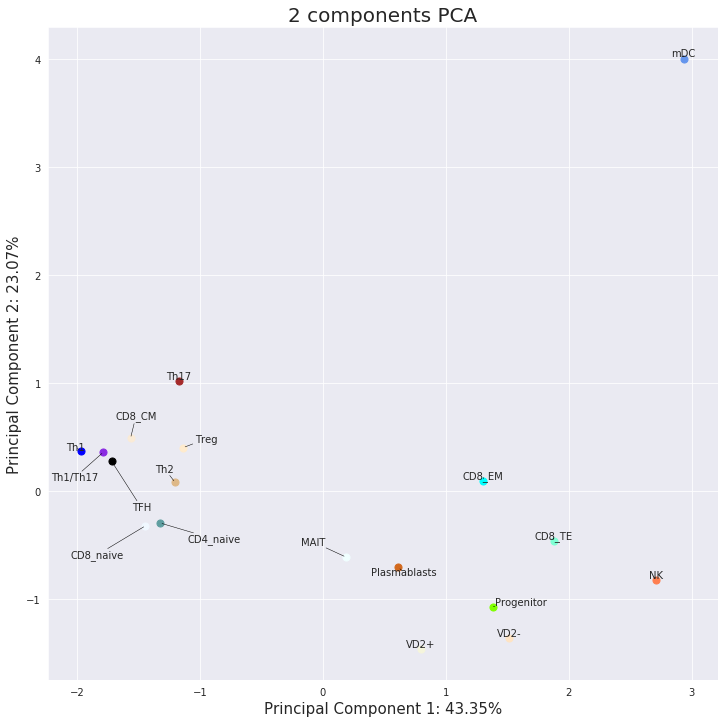

In [10]:
# Compute and display PCA for high HHI cell types
pca_data = pd.DataFrame()
for comp in high_cell_types_hhi.keys():
    pca_data[comp] = cell_types_table[comp]
features = list(pca_data.columns)
pca_data['cell'] = pca_data.index
# Excluding sparse cell types previously analysed
if len(user_sparse_cells) > 0:
    pca_data = pca_data.drop(user_sparse_cells)
else:
    pca_data = pca_data.drop(sparse_cells)
# Separating out the features
x = pca_data.loc[:, features].values
# Separating out the cell types
y = pca_data.loc[:,['cell']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
dim_1 = round(pca.explained_variance_ratio_[0] * 100, 2)
dim_2 = round(pca.explained_variance_ratio_[1] * 100, 2)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf['cell'] = list(pca_data.index)
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1: ' + str(dim_1) + '%', fontsize = 15)
ax.set_ylabel('Principal Component 2: ' + str(dim_2) + '%', fontsize = 15)
ax.set_title('2 components PCA', fontsize = 20)
cells = list(pca_data.index)
colors = list(mcd.CSS4_COLORS.keys())[:50]
x = []
y = []
texts = []
for cell, color in zip(cells, colors):
    indicesToKeep = principalDf['cell'] == cell
    texts.append(principalDf.loc[indicesToKeep, 'cell'].values[0])
    xaxis = principalDf.loc[indicesToKeep, 'principal component 1']
    yaxis = principalDf.loc[indicesToKeep, 'principal component 2']
    x.append(xaxis)
    y.append(yaxis)
    ax.scatter(xaxis, yaxis, c = color, s = 50)
txt = []
for x, y, s in zip(x, y, texts):
    txt.append(plt.text(x, y, s))
_ = adjust_text(txt, x=x, y=x, autoalign='y', only_move={'points':'y', 'text':'xy'}, expand_text=(2, 3), arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

In [11]:
# Loading user defined cell types groups and cell types proportion find in each sample
groups_and_proportion = pd.read_csv(facs_file)
groups_and_proportion.dropna(how='any', inplace=True)
#display(groups_and_proportion)
cell2group = {}
group2cell = {}
label_color_dict = {}
for row in groups_and_proportion.index:
    current_cell_type = groups_and_proportion['id'][row]
    current_group = groups_and_proportion['Grouping for RNA-Seq deconvolution'][row]
    cell2group[current_cell_type] = current_group
    group2cell.setdefault(current_group, []).append(current_cell_type)
display(groups_and_proportion)

,id,Label,Grouping for RNA-Seq deconvolution,Grouping ABIS,925L,9JD4,DZQV,G4YW,453W,684C,CR3L,FLWA,FY2H,CYFZ,4DUY,CZJE,36TS
0,B_Ex,B Ex,B Memory,B Memory,0.127,0.440,0.165,0.280,0.093,0.270,0.100,0.180,0.087,0.200,0.098,0.220,0.210
1,B_naive,B Naive,B Naive,B Naive,12.734,4.700,3.516,3.640,2.750,6.740,8.380,5.450,6.020,5.690,5.190,6.960,4.150
2,B_NSM,B NSM,B Naive,B Memory,1.151,1.120,1.719,1.310,1.560,1.160,1.020,1.010,0.390,1.080,1.200,2.980,1.070
3,B_SM,B SM,B Memory,B Memory,1.560,1.770,1.700,1.810,0.720,1.060,1.110,1.580,0.430,1.220,0.880,2.530,1.310
4,Basophils,Basophils LD,Basophils LD,Basophils LD,3.740,1.970,0.790,0.470,0.950,1.850,2.040,2.620,1.200,1.360,2.090,1.440,2.750
5,C_mono,Monocytes C,Monocytes C,Monocytes C,17.000,14.600,11.570,18.600,19.400,19.600,14.000,19.600,26.800,11.100,17.300,19.600,24.700
6,CD4_naive,T CD4 Naive,Naive T cells,T CD4 Naive,3.276,11.561,12.152,9.348,9.165,10.051,10.871,6.084,8.098,5.531,11.972,6.133,5.738
9,CD8_EM,T CD8 EM,CD8 activated,T CD8 Memory,1.692,1.000,2.760,0.925,2.242,1.000,0.554,1.163,1.645,1.194,0.488,1.747,1.530
10,CD8_naive,T CD8 Naive,Naive T cells,T CD8 Naive,5.874,10.873,10.412,8.613,5.328,8.411,11.532,3.815,5.279,3.346,6.931,9.983,2.423
11,CD8_TE,T CD8 TE,CD8 activated,T CD8 Memory,10.245,11.186,9.950,3.313,20.346,5.978,2.931,3.272,10.250,23.097,4.637,2.606,12.569


## Re-plot PCA of meta-cells components representing numerous cell types, coloring cell types according to their groups

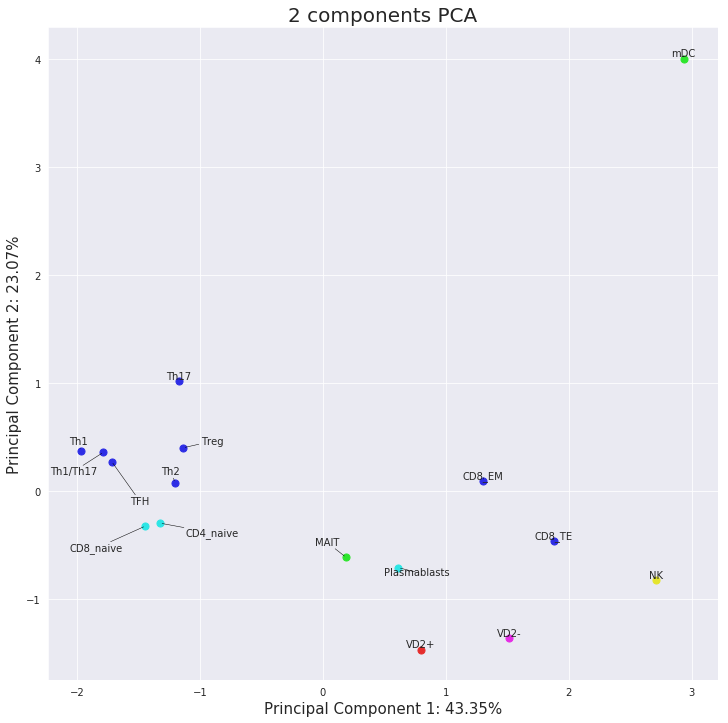

In [12]:
label_color_dict = {label:idx for idx,label in enumerate(list(set(groups_and_proportion['Grouping for RNA-Seq deconvolution'])))}
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1: ' + str(dim_1) + '%', fontsize = 15)
ax.set_ylabel('Principal Component 2: ' + str(dim_2) + '%', fontsize = 15)
ax.set_title('2 components PCA', fontsize = 20)
cells = list(pca_data.index)
x = []
y = []
texts = []
colors = generate_palette(len(cells))
for cell in cells:
    try:
        indicesToKeep = principalDf['cell'] == cell
        color = label_color_dict[cell2group[principalDf.loc[indicesToKeep, 'cell'].values[0]]]
        texts.append(principalDf.loc[indicesToKeep, 'cell'].values[0])
        xaxis = principalDf.loc[indicesToKeep, 'principal component 1']
        yaxis = principalDf.loc[indicesToKeep, 'principal component 2']
        x.append(xaxis)
        y.append(yaxis)
        ax.scatter(xaxis, yaxis, c = colors[color], s = 50)
    except KeyError:
        # cell not in a user defined group
        continue
txt = []
for x, y, s in zip(x, y, texts):
    txt.append(plt.text(x, y, s))
_ = adjust_text(txt, x=x, y=x, autoalign='y', only_move={'points':'y', 'text':'xy'}, expand_text=(2, 3), arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

## Application of the proportion table to each gene

In [13]:
proportions = {groups_and_proportion['id'][row]:{replicate: groups_and_proportion[replicate][row] for replicate in replicates.keys()} for row in groups_and_proportion.index}
grouped_data_headers = []
for replicate in replicates.keys():
    for cell_type_group in group2cell.keys():
        grouped_data_headers.append(replicate + '_' + str(cell_type_group).replace(' ', '_'))
grouped_data_table = pd.DataFrame(columns=grouped_data_headers)
for row in refined_df.index:
    gene = refined_df['id'][row]
    current_grouped_row = {header: 0 for header in grouped_data_headers}
    current_deno = {header: 0 for header in grouped_data_headers}
    for col in replicates_order:
        replicate = col.split('_')[0]
        cell_type = '_'.join(col.split('_')[1:])
        if cell_type in cell2group.keys():
            # If not, that's because this cell type is not in user's defined groups
            cell_type_group = cell2group[cell_type]
            current_grouped_row[replicate + '_' + str(cell_type_group).replace(' ', '_')] += refined_df[col][row] * proportions[cell_type][replicate]
            current_deno[replicate + '_' + str(cell_type_group).replace(' ', '_')] += proportions[cell_type][replicate]
    for k in current_grouped_row.keys():
        current_grouped_row[k] = round(current_grouped_row[k] / current_deno[k], 3)
    current_grouped_row = pd.Series(current_grouped_row)
    current_grouped_row.name = gene
    grouped_data_table = grouped_data_table.append(current_grouped_row)
grouped_data_table.head()

,925L_B_Memory,925L_B_Naive,925L_Basophils_LD,925L_Monocytes_C,925L_Naive_T_cells,925L_CD8_activated,925L_Monocytes_NC+I,925L_MAIT,925L_mDCs,925L_Neutrophils_LD,925L_NK,925L_pDCs,925L_Plasmablasts,925L_CD4+_effector,925L_VD2-,925L_VD2+,9JD4_B_Memory,9JD4_B_Naive,9JD4_Basophils_LD,9JD4_Monocytes_C,9JD4_Naive_T_cells,9JD4_CD8_activated,9JD4_Monocytes_NC+I,9JD4_MAIT,9JD4_mDCs,9JD4_Neutrophils_LD,9JD4_NK,9JD4_pDCs,9JD4_Plasmablasts,9JD4_CD4+_effector,9JD4_VD2-,9JD4_VD2+,DZQV_B_Memory,DZQV_B_Naive,DZQV_Basophils_LD,DZQV_Monocytes_C,DZQV_Naive_T_cells,DZQV_CD8_activated,DZQV_Monocytes_NC+I,DZQV_MAIT,DZQV_mDCs,DZQV_Neutrophils_LD,DZQV_NK,DZQV_pDCs,DZQV_Plasmablasts,DZQV_CD4+_effector,DZQV_VD2-,DZQV_VD2+,G4YW_B_Memory,G4YW_B_Naive,G4YW_Basophils_LD,G4YW_Monocytes_C,G4YW_Naive_T_cells,G4YW_CD8_activated,G4YW_Monocytes_NC+I,G4YW_MAIT,G4YW_mDCs,G4YW_Neutrophils_LD,G4YW_NK,G4YW_pDCs,G4YW_Plasmablasts,G4YW_CD4+_effector,G4YW_VD2-,G4YW_VD2+
37135,2841.247,4293.843,4171.000,1860.080,5218.695,4356.610,1457.439,3301.880,2917.720,3299.870,2062.740,5322.290,2417.840,5572.991,3655.620,2839.230,2874.525,2149.206,675.216,2321.480,3698.099,7263.497,1652.348,2665.540,885.632,3220.930,3401.260,2690.300,1536.520,4618.644,3673.850,5758.320,7063.964,4625.797,2090.040,1955.760,2998.098,2101.478,3196.414,1719.140,1758.080,3152.420,9284.080,8138.720,1519.370,5752.848,2954.090,5882.590,4852.455,2071.319,6949.180,1490.150,1804.642,4878.825,890.914,4342.150,904.444,1876.050,3650.750,1864.750,560.835,2591.023,2030.260,3400.960
37316,10.293,6.399,0.496,1.642,12.829,11.547,3.182,13.482,2.815,0.000,11.350,5.919,3.303,8.213,17.640,15.060,10.667,9.386,0.830,4.906,14.740,11.725,6.267,11.317,5.425,0.000,12.604,9.294,5.305,9.422,11.237,17.177,6.817,5.953,1.847,3.522,7.098,8.097,2.303,8.116,5.530,0.000,8.208,4.459,2.901,6.290,15.916,7.858,9.917,8.294,0.406,2.292,9.244,7.922,4.089,9.625,6.780,0.000,9.792,5.624,7.068,8.703,10.724,10.351
37500,290.694,234.681,369.987,316.812,405.708,317.519,271.932,342.327,281.924,103.999,450.710,600.019,118.750,368.176,376.843,342.205,333.101,298.860,453.242,285.328,311.783,423.965,265.880,305.712,390.771,102.545,441.877,562.038,159.826,340.624,336.389,384.401,300.971,253.913,566.927,372.160,323.304,285.918,319.033,384.917,323.690,86.806,368.610,542.595,118.815,352.599,350.256,284.214,222.307,256.795,483.323,261.490,279.713,316.553,266.461,276.344,346.539,76.658,390.838,502.795,140.937,277.962,315.104,243.890
37865,0.076,0.028,0.214,0.076,0.176,0.169,0.173,0.085,1.194,0.034,0.132,1.445,0.012,0.140,0.196,0.105,0.088,0.131,0.296,0.054,0.135,0.078,0.227,0.083,1.554,0.113,0.207,0.454,0.372,0.165,0.207,0.120,0.069,0.036,0.375,0.096,0.140,0.156,0.198,0.076,1.355,0.025,0.208,0.048,0.000,0.138,0.291,0.038,1.329,0.258,0.210,0.055,0.051,0.127,0.015,0.136,1.551,0.027,0.354,0.566,0.015,0.132,0.038,0.000
38231,4.740,4.085,2.469,5.655,2.335,9.474,2.189,4.383,1.408,2.553,8.456,1.385,0.072,2.766,0.921,9.974,2.217,2.604,1.522,5.977,2.501,4.890,1.435,3.795,3.463,2.291,2.886,5.052,0.573,2.088,1.561,1.678,7.677,2.755,2.126,12.438,1.250,5.746,2.025,7.112,1.394,9.293,1.156,5.143,0.124,2.110,11.977,5.428,1.237,4.424,4.952,10.830,1.940,3.629,1.103,8.188,2.382,4.420,5.762,1.667,0.197,3.052,4.523,4.121


## For each gene, get the cell type group where it is the most expressed (and in how many replicate it happen), corresponding median and gene HHI

In [14]:
# Start from transposed normalized counts matrix
transposed_normalized_counts = grouped_data_table.transpose()

# Compute genes HHI
hhi_genes = compute_hhi(transposed_normalized_counts)

# Retrieve for each gene in which cell type group it is the most expressed
# Sort rows by cell types, then by replicates
ordered_transposed_normalized_counts = pd.DataFrame(columns=gene_order)
ordered_table_index = []
for cell_type in group2cell.keys():
    for replicate in replicates:
        ordered_table_index.append(replicate + '_' + cell_type.replace(' ', '_'))
for idx in ordered_table_index:
    ordered_transposed_normalized_counts = ordered_transposed_normalized_counts.append(transposed_normalized_counts.loc[idx])

# Iterate on genes (columns) to compute counts ranks: most expressed line (=replicate/cell_type) is rank 1, second is rank 2, etc.
gene_abundance = {}
for gene in gene_order:
    gene_abundance[gene] = {}
    current_gene_ordered_counts = list(ordered_transposed_normalized_counts[gene])
    cell_type_abundance_rank = len(current_gene_ordered_counts) + 1 - scipy.stats.rankdata(current_gene_ordered_counts).astype(int)
    cpt = 0
    current_gene_data = []
    for count_value in ordered_transposed_normalized_counts[gene]:
        # We store for each gene the replicate, the cell type, the corresponding count and its rank
        current_gene_data.append((ordered_table_index[cpt].split('_')[0], '_'.join(ordered_table_index[cpt].split('_')[1:]), count_value, cell_type_abundance_rank[cpt]))
        cpt += 1
    # Here we identify in which cell type the current gene is the most expressed,
    # we count how many replicates have a rank lower or equal to the number of replicates for the cell type where the current gene is the most expressed
    # and we compute the count median accross all replicates for the identified cell type.
    no_rank_1 = True
    for entry in current_gene_data:
        if entry[3] == 1:
            # current entry is rank #1
            gene_abundance[gene]["mei_cell_type"] = entry[1]
            gene_abundance[gene]["count_max"] = entry[2]
            number_on_top = 1
            current_median_values = [entry[2]]
            for new_entry in current_gene_data:
                if new_entry[0] != entry[0] and new_entry[1] == entry[1]:
                    if new_entry[3] <= len(replicate):
                        number_on_top += 1
                    current_median_values.append(new_entry[2])
            gene_abundance[gene]["count_median"] = statistics.median(current_median_values)
            gene_abundance[gene]["replicates_having_mei_cell_type_on_top"] = number_on_top
            no_rank_1 = False
            break
    if no_rank_1:
        # all counts are null for current gene
        gene_abundance[gene]["mei_cell_type"] = np.nan
        gene_abundance[gene]["count_max"] = np.nan
        gene_abundance[gene]["count_median"] = np.nan
        gene_abundance[gene]["replicates_having_mei_cell_type_on_top"] = np.nan

cell_type_column = []
median_column = []
HHI_column = list(hhi_genes.values())
number_replicates_top_column = []
for gene in gene_order:
    cell_type_column.append(gene_abundance[gene]["mei_cell_type"])
    median_column.append(gene_abundance[gene]["count_median"])
    number_replicates_top_column.append(gene_abundance[gene]["replicates_having_mei_cell_type_on_top"])
# Put all results in a table
signature_dict = {'Cell type': cell_type_column, 
                  'Median TPM 1st': median_column, 
                  "HHI": HHI_column, 
                  "N on top": number_replicates_top_column}
signature_df = pd.DataFrame(signature_dict, index=gene_order)
signature_df.dropna(how='any', inplace=True)
display(signature_df)

,Cell type,Median TPM 1st,HHI,N on top
id,,,,
37135,NK,3526.0050,48.721867,1.0
37316,VD2-,13.5765,46.977895,2.0
37500,pDCs,552.3165,56.940039,3.0
37865,mDCs,1.4530,19.985379,3.0
38231,Monocytes_C,8.4035,40.638273,2.0
38596,Neutrophils_LD,11.6870,8.236554,4.0
38961,Naive_T_cells,277.6225,50.863461,2.0
39326,NK,1035.4580,52.315697,2.0
39692,Basophils_LD,9.4755,36.045677,1.0


## Plots

### HHI boxplot using genes most expressed in each cell type group

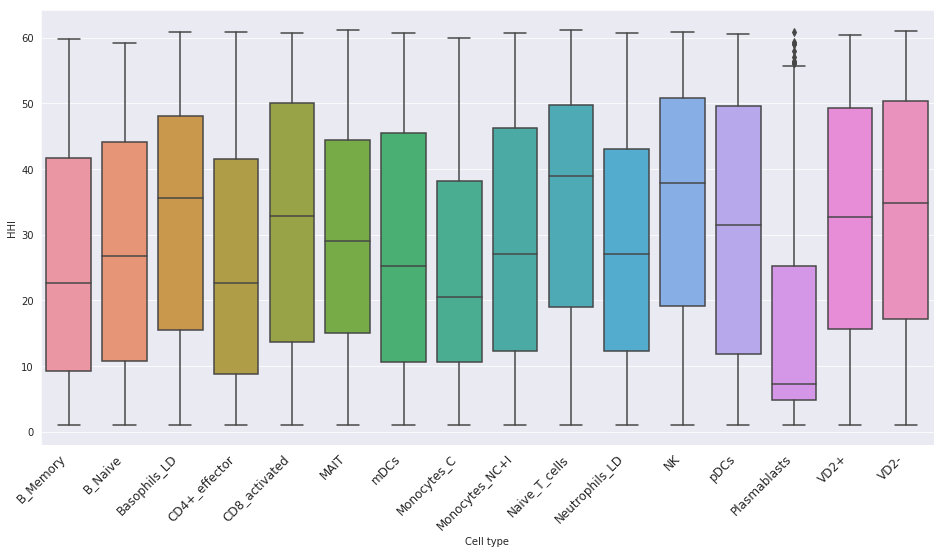

In [15]:
# HHI per cell type group boxplot
# We sort cell type groups alphabetically
sorted_signature_df = signature_df.iloc[signature_df['Cell type'].str.lower().argsort()]
plt.figure(figsize=(16,8))
chart = sns.boxplot(x="Cell type", y="HHI", data=sorted_signature_df)
_ = plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')

### Median per cell type group boxplot

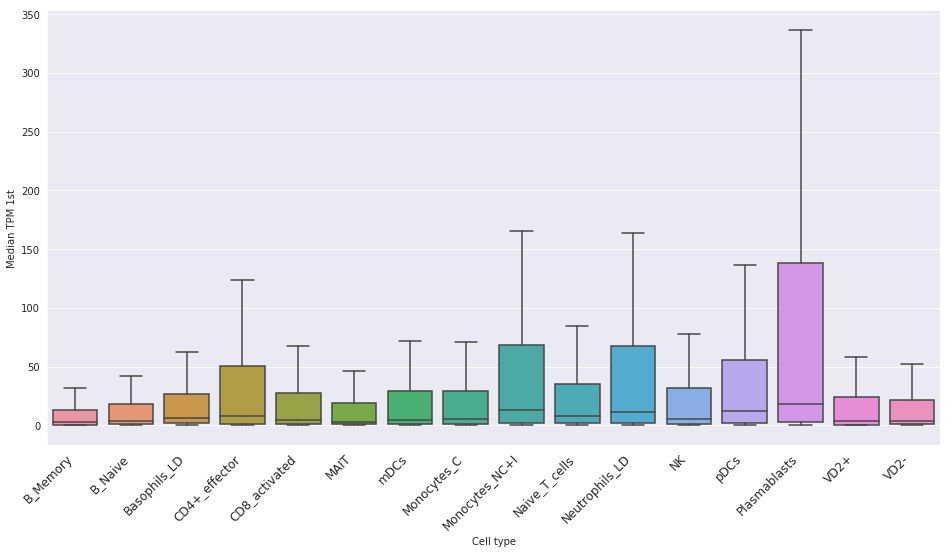

In [16]:
# Expression median per cell type group boxplot
# We cut out outliers as they tend to flat all boxes down on x axis
plt.figure(figsize=(16,8))
chart = sns.boxplot(x="Cell type", y="Median TPM 1st", data=sorted_signature_df, showfliers = False)
_ = plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')

### Filtering data to keep genes having their maximal expression in a given cell type in all replicates and having a low HHI, reflecting cell type specificity

In [17]:
# We are filtering the previous table to keep only genes having:
# - [criteria 1] Their max expression in the same cell types group for all replicates
# - [criteria 2] A HHI lower or equal to the number of replicates

# First, we split the table into group-related subtables
signature_per_group = {}
for group in group2cell.keys():
    signature_per_group[group] = signature_df.loc[(signature_df['Cell type'] == str(group).replace(' ', '_'))]
    
c1_filtered_signature_per_group = {}
c2_filtered_signature_per_group = {}
stats_dict = {}
signature = []

for group in signature_per_group.keys():
    # In each group, we apply our 2 criteria
    replicates_threshold = len(replicates.keys())
    hhi_threshold = len(replicates.keys())
    c1_filtered_signature_per_group[group] = filter_df(signature_per_group[group], 'N on top', replicates_threshold, '>=')
    c2_filtered_signature_per_group[group] = filter_df(signature_per_group[group], 'HHI', hhi_threshold, '<=')
    first_key = c1_filtered_signature_per_group[group].keys()[0]
    c1_genes = list(c1_filtered_signature_per_group[group][first_key].keys())
    c2_genes = list(c2_filtered_signature_per_group[group][first_key].keys())
    # We do the intersection of genes obtained by each criteria
    c1_c2_intersection = list(set(c1_genes) & set(c2_genes))
    
    # We wish to have at least 30 marker genes for each group.
    # If we didn't get as many so far, we have to relax the 
    while len(c1_c2_intersection) < 30:
        # Relax HHI threshold first
        if hhi_threshold < 10.5 :
            hhi_threshold += 0.05
            c2_filtered_signature_per_group[group] = filter_df(signature_per_group[group], 'HHI', hhi_threshold, '<=')
        # Then relax replicates threshold if we still don't have 30 genes
        else:
            if replicates_threshold > 2:
                replicates_threshold -= 1
                c1_filtered_signature_per_group[group] = filter_df(signature_per_group[group], 'N on top', replicates_threshold, '>=')
            else:
                # This happen when we're unable to obtain 30 genes fully relaxing both thresholds
                c1_genes = list(c1_filtered_signature_per_group[group][first_key].keys())
                c2_genes = list(c2_filtered_signature_per_group[group][first_key].keys())
                c1_c2_intersection = list(set(c1_genes) & set(c2_genes))
                break
        c1_genes = list(c1_filtered_signature_per_group[group][first_key].keys())
        c2_genes = list(c2_filtered_signature_per_group[group][first_key].keys())
        c1_c2_intersection = list(set(c1_genes) & set(c2_genes))
    
    stats_dict.setdefault('Cell type', []).append(group)
    stats_dict.setdefault('min N on top', []).append(replicates_threshold)
    stats_dict.setdefault('max HHI', []).append(hhi_threshold)
    stats_dict.setdefault('Gene number', []).append(len(c1_c2_intersection))
    signature.extend(c1_c2_intersection)
    c1_data = pd.concat(list(c1_filtered_signature_per_group.values()))
    c2_data = pd.concat(list(c2_filtered_signature_per_group.values()))
    #filtered_data = pd.merge(c1_data, c2_data, how='inner', on=['id'])
    filtered_data = pd.concat([c1_data, c2_data], axis=1, join='inner')
    filtered_data = filtered_data.loc[:,~filtered_data.columns.duplicated()]
    
stats_table = pd.DataFrame(stats_dict)
display(stats_table)

,Cell type,min N on top,max HHI,Gene number
0,B Memory,4,6.95,30
1,B Naive,4,6.05,30
2,Basophils LD,4,4.00,125
3,Monocytes C,4,9.50,30
4,Naive T cells,4,8.45,30
5,CD8 activated,2,10.50,51
6,Monocytes NC+I,4,5.15,30
7,MAIT,4,10.30,30
8,mDCs,4,7.65,30
9,Neutrophils LD,4,4.00,62


### Display Signature

In [18]:
print("Signature size:", len(filtered_data))
pd.set_option('display.max_rows', None)
display(filtered_data)
pd.set_option('display.max_rows', 60)

Signature size: 750


,Cell type,Median TPM 1st,HHI,N on top
id,,,,
AC013444.1,B_Memory,4.7010,6.416717,4.0
AK8,B_Memory,15.6755,4.727970,4.0
ARL14,B_Memory,1.3730,4.364591,4.0
C12orf74,B_Memory,9.1245,4.802246,4.0
COCH,B_Memory,256.2330,5.466716,4.0
DNAJC5B,B_Memory,20.5870,6.819735,4.0
EBI3,B_Memory,19.9090,6.089662,4.0
FRZB,B_Memory,2.0755,4.516876,4.0
IGHVIII-11-1,B_Memory,15.8380,4.557117,4.0


### HHI boxplot on the table filtered by genes having their max expression in the same cell types group for all replicates

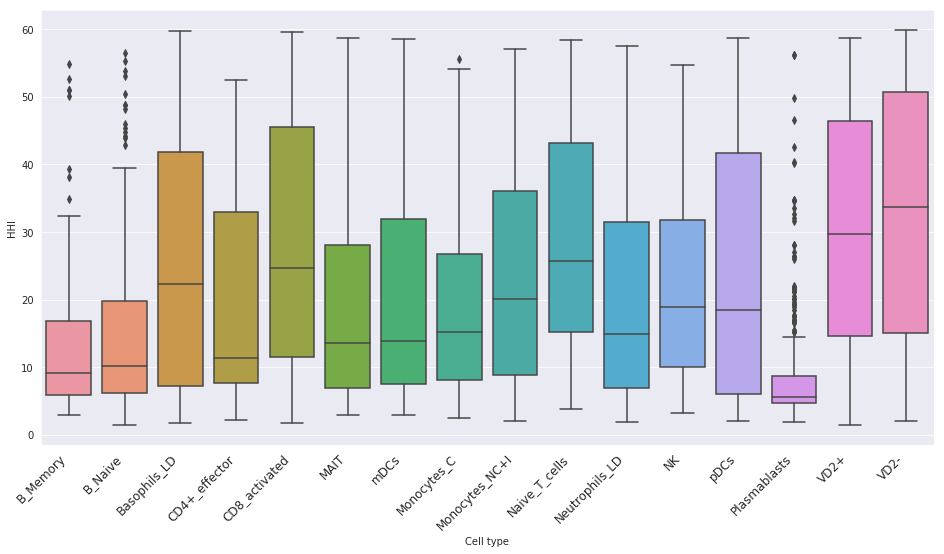

In [19]:
# HHI per cell type group boxplot for genes having their max expression in the same cell types group for all replicates
sorted_c1_data = c1_data.iloc[c1_data['Cell type'].str.lower().argsort()]
plt.figure(figsize=(16,8))
chart = sns.boxplot(x="Cell type", y="HHI", data=sorted_c1_data)
_ = plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')

### Median boxplot on the table filtered by genes having their max expression in the same cell types group for all replicates

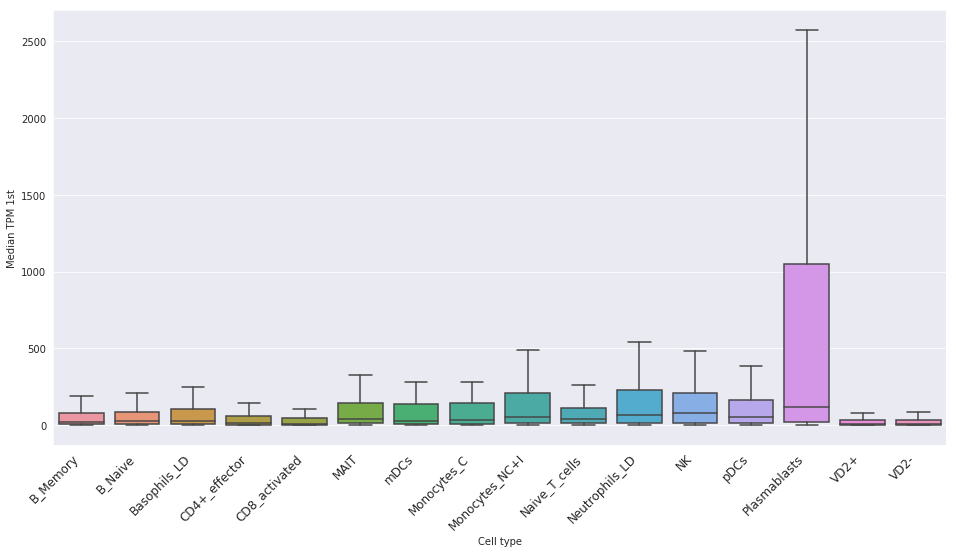

In [20]:
# Expression median per cell type group boxplot for genes having their max expression in the same cell types group for all replicates
# We cut out outliers as they tend to flat all boxes down on x axis
plt.figure(figsize=(16,8))
chart = sns.boxplot(x="Cell type", y="Median TPM 1st", data=sorted_c1_data, showfliers = False)
_ = plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')

## Download all tables

In [ ]:
# NTF analysis-ready table (cell #4)
csv_download(df, 'NTF_ready_data')

In [ ]:
# cell types components table from NTF analysis (cell #6)
csv_download(cell_types_table, "cell_types_components")

In [ ]:
# subjects components table from NTF analysis (cell #7)
csv_download(replicates_table, "replicates_components")

In [ ]:
# inverse Herfindahl–Hirschman Index (HHI) table for cell lines and replicates (cell #8)
csv_download(hhi_plot_table, "cell_types_and_replicates_HHI")

In [ ]:
# Table of gene expression weighted by proportions in each replicate / cell type group (cell #13)
csv_download(grouped_data_table, "weighted_gene_expression_in_groups")

In [ ]:
# Table summarizing for each gene the cell type group where it is the most expressed (and in how many replicate it happen),
# corresponding median and gene HHI (cell #14)
csv_download(signature_df, "genes_max_expression_cell_type_group")

In [ ]:
# Previous table filtered to only keep genes having:
# - [criteria 1] Their max expression in the same cell types group for all replicates
# - [criteria 2] A HHI lower or equal to the number of replicates
# (cell #18)
csv_download(filtered_data, "signature")

In [ ]:
# Summary of gene number kept during filtering and threshold used, as we modify those to try to get 30 genes per cell type group (cell #18)
csv_download(filter_stats, "filtering_summary")